In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer


class selected_variables_object:
  def __init__(self,final_data, target_var, initial_train_size):
    self.final_data = final_data
    self.target_var = target_var
    self.initital_train_size = initial_train_size

import pickle
# Load the object from the file
with open('selected_variables_10Y_UST_v2.pkl', 'rb') as file:
    selected_variables_obj = pickle.load(file)



df = selected_variables_obj.final_data
target_var = selected_variables_obj.target_var
initial_train_size = selected_variables_obj.initial_train_size
selected_vars = selected_variables_obj.selected_vars


14

In [20]:
# Assuming df4 is your DataFrame
df2 = df.copy()
# Define your features and target variable
features = df2.columns
features2 = [feature for feature in features if feature != target_var]


# replace inf and -inf with na and  drops rows with missing values in the lagged variables
drop_after_here = pd.DataFrame(selected_vars).loc[:,1].max()
df3 = df2[drop_after_here:]
df3 = df3.replace([np.inf, -np.inf], np.nan).dropna(axis = 1)

In [22]:
df3[target_var] = np.where(df3[target_var] < 0, 'LONG', 'SHORT')
X = df3.drop(target_var, axis=1)
y = df3[target_var]

if target_var.lower() in map(str.lower, X.columns):
    print(f"The DataFrame contains the column '{target_var}'. ABORT BACK-TEST")
else:
    print(f"The DataFrame X does not contain the target variable: '{target_var}'. You may proceed with the back-test.")


The DataFrame X does not contain the target variable: 'YIELD_weekly_percent_change_10 YR_lead'. You may proceed with the back-test.


                                                                    
                                                                    ## Gridsearch performed below ##

In [23]:
# Set up the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 50],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.75],
    'max_depth': [5, 15, 25],
    'min_samples_leaf': [1,2]
}

# param_grid = {
#     'n_estimators': [50],
#     'learning_rate': [0.3],
#     'subsample': [0.75],
#     'max_depth': [5,15],
#     'min_samples_leaf': [5]
# }

# Initialize the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=248)


ys = []

def Acc_Score(y_true,y_pred):
    global ys
    ys.append(y_pred)
    acc = accuracy_score(y_true, y_pred)    
    return acc

def scorer():
    return make_scorer(Acc_Score, greater_is_better=True)

# Create the time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=len(df3) - initial_train_size, test_size=1,gap=0, max_train_size=None)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbm, param_grid, cv=tscv, scoring=scorer(), verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Get the best model from the grid search
best_gbm = grid_search.best_estimator_

cv_results = pd.DataFrame(grid_search.cv_results_)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print(f'Accuracy of the Best Hyperparameters: {grid_search.best_score_:.4f}')


Fitting 310 folds for each of 24 candidates, totalling 7440 fits


: 

In [12]:
param_grid2 = {
    'n_estimators': [150],
    'learning_rate': [0.01],
    'subsample': [0.75],
    'max_depth': [15],
    'min_samples_leaf': [1]
}
ys = []
# Perform grid search with cross-validation
grid_search2 = GridSearchCV(gbm,param_grid2, cv=tscv, scoring=scorer(), verbose=1)#, n_jobs=-1)
grid_search2.fit(X, y)
# Get the best model from the grid search
best_gbm2 = grid_search2.best_estimator_

cv_results2 = pd.DataFrame(grid_search2.cv_results_)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search2.best_params_)
print(f'Accuracy of the Best Hyperparameters: {grid_search2.best_score_:.4f}')

Fitting 272 folds for each of 1 candidates, totalling 272 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 150, 'subsample': 0.75}
Accuracy of the Best Hyperparameters: 0.5478


In [13]:
from sklearn.metrics import confusion_matrix 
#Calculate and display accuracy
accuracy_score(y[(initial_train_size):], ys[(((len(df3) - initial_train_size) * (grid_search2.best_index_))):(len(df3) - initial_train_size) * (grid_search2.best_index_ +1)])

0.5477941176470589

In [14]:
import joblib
# save the model to disk
filename = '10Y_UST_gridsearch_results.sav'
joblib.dump(grid_search, filename)

['10Y_UST_gridsearch_results.sav']

In [15]:
best_estim_preds = ys[(((len(df3) - initial_train_size) * (grid_search2.best_index_))):(len(df3) - initial_train_size) * (grid_search2.best_index_ +1)]

In [16]:
best_estim_preds = np.array(best_estim_preds).flatten().tolist()


In [17]:
joblib.dump(best_estim_preds,'10Y_UST_best_estimator_predictions.sav')

['10Y_UST_best_estimator_predictions.sav']

In [18]:
class backtest_object:
  def __init__(self,grid_search, X, y, best_estim_preds, final_model):
    self.grid_search = grid_search
    self.X = X
    self.y = y
    self.best_estim_preds = best_estim_preds
    self.final_model = best_gbm

backtest_object_10Y_UST_v1_1 = backtest_object(grid_search, X, y, best_estim_preds, best_gbm)
print(backtest_object_10Y_UST_v1_1)

import pickle

# Serialize the object using pickle and save to a file
with open('backtest_object_10Y_UST_v1_1.pkl', 'wb') as file:
    pickle.dump(backtest_object_10Y_UST_v1_1, file)
    


code for predicting off of new data

In [19]:
grid_search2.best_estimator_.predict(X.tail(1))

array(['SHORT'], dtype=object)

In [20]:
grid_search2.best_estimator_.predict_proba(X.tail(1))

array([[0.17409179, 0.82590821]])

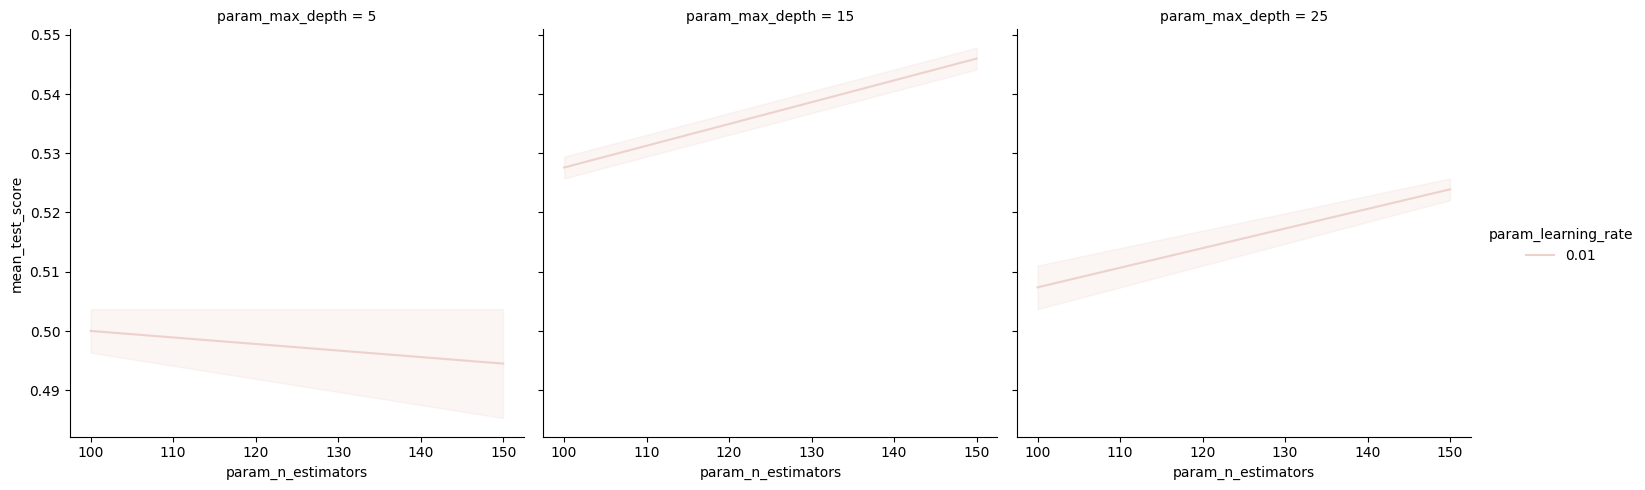

In [21]:
# https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/
import matplotlib.pyplot as plt
import seaborn as sns 
sns.relplot(data=cv_results,
 kind='line',
 x='param_n_estimators',
 y='mean_test_score',
 hue='param_learning_rate',
 col='param_max_depth')
plt.show()

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

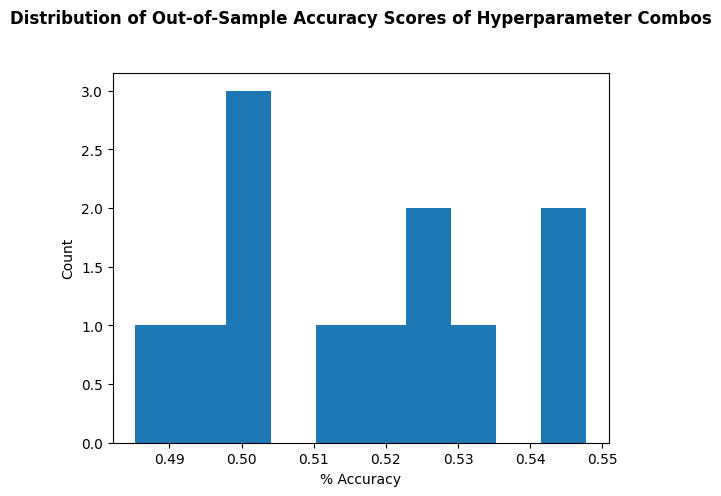

In [22]:

plt.hist(cv_results['mean_test_score'])
plt.xlabel('% Accuracy')
plt.ylabel('Count')
 
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

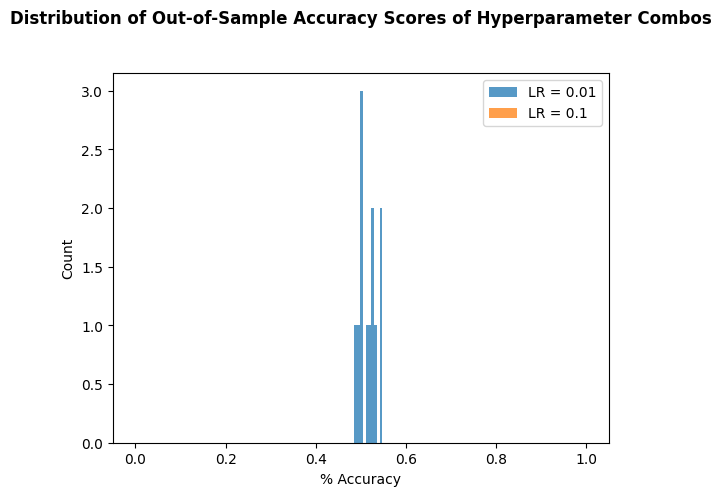

In [23]:
import matplotlib.pyplot as plt
group1 = cv_results.query('param_learning_rate == 0.01')
group2 = cv_results.query('param_learning_rate == 0.1')

plt.hist(group1['mean_test_score'], label='LR = 0.01', alpha=0.75)
plt.hist(group2['mean_test_score'], label='LR = 0.1', alpha=0.75)
plt.xlabel('% Accuracy')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

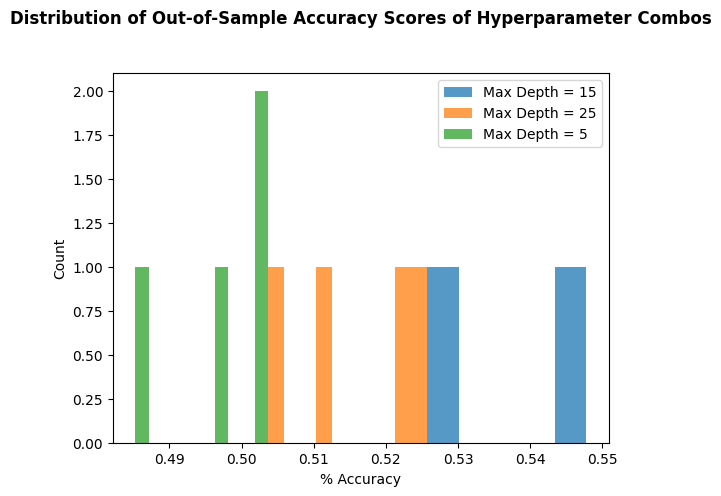

In [32]:
import matplotlib.pyplot as plt
group1 = cv_results.query('param_max_depth == 15')
group2 = cv_results.query('param_max_depth == 25')
group3 = cv_results.query('param_max_depth == 5')
plt.hist(group1['mean_test_score'], label='Max Depth = 15', alpha=0.75)
plt.hist(group2['mean_test_score'], label='Max Depth = 25', alpha=0.75)
plt.hist(group3['mean_test_score'], label='Max Depth = 5', alpha=0.75)
plt.xlabel('% Accuracy')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

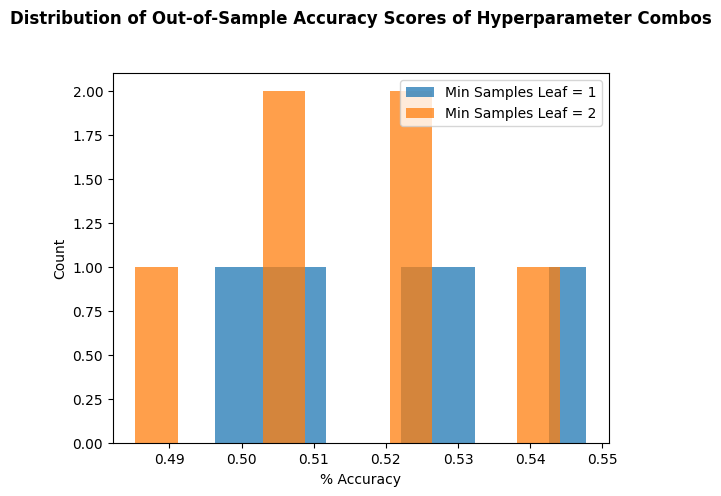

In [33]:
import matplotlib.pyplot as plt
group1 = cv_results.query('param_min_samples_leaf == 1')
group2 = cv_results.query('param_min_samples_leaf == 2')

plt.hist(group1['mean_test_score'], label='Min Samples Leaf = 1', alpha=0.75)
plt.hist(group2['mean_test_score'], label='Min Samples Leaf = 2', alpha=0.75)
plt.xlabel('% Accuracy')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

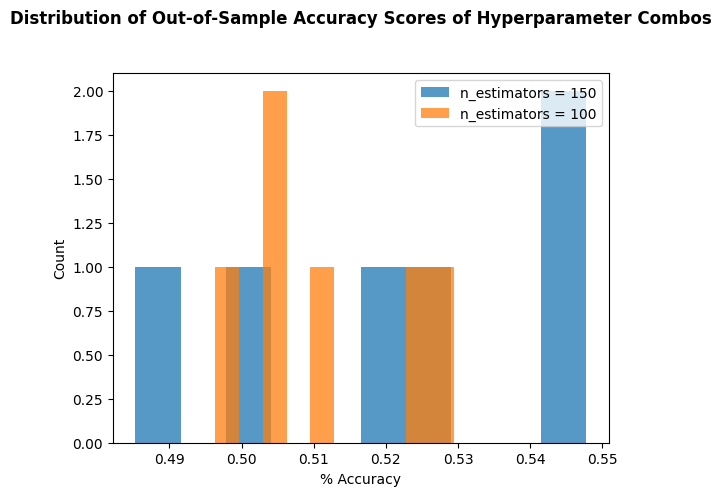

In [34]:
import matplotlib.pyplot as plt
group1 = cv_results.query('param_n_estimators == 150')
group2 = cv_results.query('param_n_estimators == 100')

plt.hist(group1['mean_test_score'], label='n_estimators = 150', alpha=0.75)
plt.hist(group2['mean_test_score'], label='n_estimators = 100', alpha=0.75)
plt.xlabel('% Accuracy')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

Text(0.5, 1.0, 'Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n')

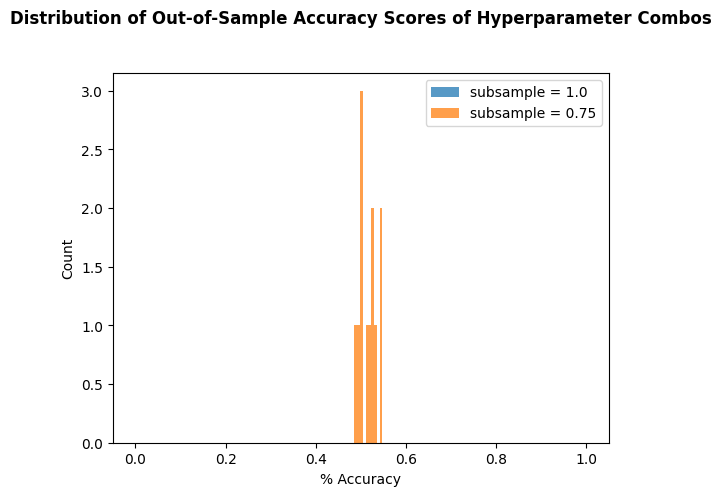

In [27]:
import matplotlib.pyplot as plt
group1 = cv_results.query('param_subsample == 1')
group2 = cv_results.query('param_subsample == .75')

plt.hist(group1['mean_test_score'], label='subsample = 1.0', alpha=0.75)
plt.hist(group2['mean_test_score'], label='subsample = 0.75', alpha=0.75)
plt.xlabel('% Accuracy')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('Distribution of Out-of-Sample Accuracy Scores of Hyperparameter Combos\n\n',
          fontweight = "bold")

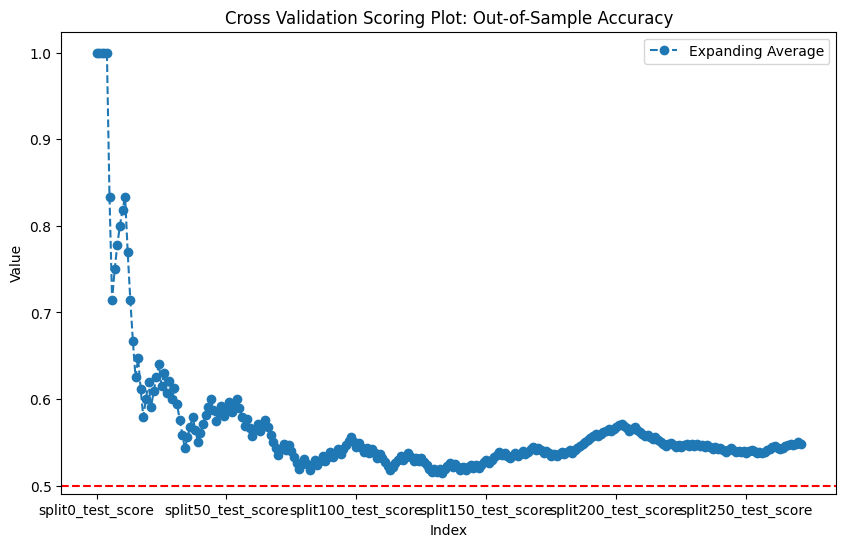

In [28]:
# plot your own learning curve

cv_perf = pd.DataFrame(cv_results2.loc[0,"split0_test_score":'split271_test_score'])
cv_perf = cv_perf.rename(columns={0: 'score'})
cv_perf['Expanding_Average'] = cv_perf['score'].expanding().mean()
#cv_perf.reindex(X.index[(len(df6) - initial_train_size):])
# Plot the expanding average
plt.figure(figsize=(10, 6))
#plt.plot(cv_perf['Value'], label='Original Values', marker='o')
plt.plot(cv_perf['Expanding_Average'], label='Expanding Average', linestyle='--', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Cross Validation Scoring Plot: Out-of-Sample Accuracy')
plt.legend()
# Show only every 10th tick on the x-axis
plt.xticks(cv_perf.index[::50])
plt.axhline(y=0.50, color='red', linestyle='--')

plt.show()


In [29]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve, train_test_split

# # Get the best estimator from the grid search
# best_gbm = grid_search.best_estimator_

# # Plot learning curve
# train_sizes, train_scores, test_scores = learning_curve(best_gbm, X_train, y_train, cv=tscv, scoring=make_scorer(accuracy_score), train_sizes=np.ones((len(df6) - initial_train_size)))

# # Calculate mean and standard deviation for training set scores and test set scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plot the learning curve
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue', marker='o')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
# plt.plot(train_sizes, test_mean, label='Cross-validation accuracy', color='red', marker='o')
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

# # Add labels and legend
# plt.title('Learning Curve for GBM Classifier')
# plt.xlabel('Number of training examples')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')

# # Show the plot
# plt.show()
